# Proposito
En este notebook estan los pasos a tomar para la etapa de **validacion** del proceso de **Data Wrangling**. Este proceso recibe como entrada las conclusiones obtenidas en la etapa anterior: **limpieza**.

Para este ejemplo, recibiremos como insumo el archivo CSV generado en el paso anterior llamado `cleaned_data.csv`.

Finalmente, no olvidemos la necesidad del negocio. Necesitamos dar respuesta a la pregunta ¿Que grupo etario trae mas mal riesgo al banco?

# Objetivos
Al finalizar este notebook deberemos de haber:

✅ Verificado la validez de los datos.

✅ Verificado la veracidad de los datos.

✅ Verificado la precision de los datos.

In [2]:
import pandas as pd
from pandas import DataFrame
import numpy as np

In [3]:
schema = {
    "Unnamed: 0.1": "Int64",
    "Unnamed: 0": "Int64",
    "Duration": "Int64",
    "Checking account": "string",
    "Credit amount": "Int64",
    "Purpose": "string",
    "Job": "string",
    "Sex": "string",
    "data_source": "string",
    "Saving accounts": "string",
    "Housing": "string",
    "Risk": "string",
    "Age": "Int64",
    "value": "string"
}  # el esquema que hallamos en el proceso anterior

df = pd.read_csv(r"../data/cleaned_data.csv", dtype=schema)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4818 entries, 0 to 4817
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0.2      4818 non-null   Int64 
 1   Unnamed: 0.1      4818 non-null   Int64 
 2   Duration          4671 non-null   Int64 
 3   Checking account  2720 non-null   string
 4   Credit amount     4548 non-null   Int64 
 5   Purpose           4658 non-null   string
 6   Job               4607 non-null   string
 7   Sex               4589 non-null   string
 8   data_source       4816 non-null   string
 9   Saving accounts   3763 non-null   string
 10  Housing           4594 non-null   string
 11  Risk              4687 non-null   string
 12  Age               4677 non-null   Int64 
 13  value             4816 non-null   string
 14  Unnamed: 0        4657 non-null   Int64 
dtypes: Int64(6), string(9)
memory usage: 593.0 KB


# Verificando la validez
La validez se refiere a ¿Qué tan bien representan mis datos lo que estoy tratando de medir? Para este caso la pregunta de negocio que estoy tratando de contestar.

Dado que es una pregunta simple la cual solo involucra dos variables, concentremonos en aquellas que responden dicha pregunta, los demas datos son ruido y dificultan el analisis para dar respuesta a la pregunta de negocio.

In [4]:
df: DataFrame = df[["Risk", "Age"]]

Una cosa a tener en cuenta para medir la validez de los datos, es verificar que la muestra sea significativa, en otras palabras, que tengamos suficientes datos representando los posibles casos. 

Por ejemplo, para la edad lo ideal seria que hubiesen una cantidad de datos parecida por cada uno de los grupos etarios, sin embargo, es complejo de que esto pase en la realidad.

<Axes: ylabel='Frequency'>

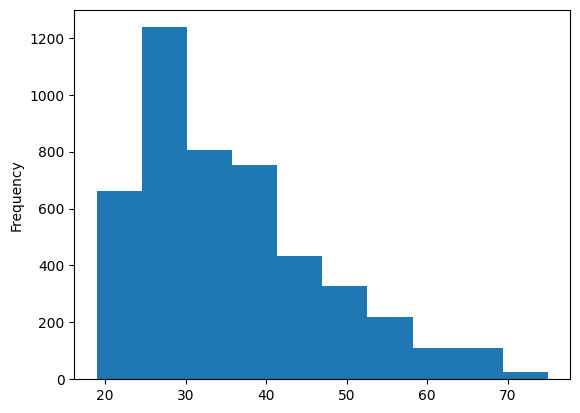

In [6]:
df["Age"].plot(kind="hist")

Como se puede observar quienes mas solicitan creditos son personas de los 30 a los 40 años de edad, asi pues, es normal que este mismo grupo etario sea quien traiga los peores riesgos por el solo hecho de que hay mas muestras para este grupo. 

En este conjunto de datos contamos con una **validez sub optima** para dar respuesta al negocio, ya que los datos se encuentran altamente sesgados.

# Verificando la veracidad
La veracidad se puede definir como ¿Qué tan reales o confiables son mis datos? 

Algunos factores que afectan la veracidad de mis datos son:

✅ Registros duplicados o inconsistentes.

✅ Datos faltantes y errores en el formato.

✅ Valores extremos o sospechosos.

Verifiquemos cada uno de estos.

In [10]:
df[df.duplicated()]  # hallar las filas donde hay duplicados

,Risk,Age
13,good,25
15,good,43
20,good,61
23,bad,28
28,good,37
...,...,...
4813,good,51
4814,good,44
4815,good,30
4816,good,23


Es normal la presencia de duplicados ya que solo estamos observando dos columnas.

In [ ]:
df.isnull().sum() / len(df) * 100  # hallar % de valores nulos x columna

Risk    2.718971
Age     2.926526
dtype: float64

Muy pocos valores nulos dentro de nuestros datos, no deberian de significar ningun problema. 

Ya que son tan pocos podemos eliminar todas las filas que contengan nulos.

In [14]:
df: DataFrame = df.dropna()

Finalmente, veamos que valores minimos y maximos hay para la edad.

In [20]:
df[df["Age"] == df["Age"].max()]

,Risk,Age
996,good,75
1569,good,75
1903,good,75
2908,good,75
3481,good,75
3815,good,75
4436,good,75


In [21]:
df[df["Age"] == df["Age"].min()]

,Risk,Age
283,bad,19
781,good,19
1368,bad,19
1565,bad,19
1829,good,19
2195,bad,19
2693,good,19
3280,bad,19
3477,bad,19
3741,good,19


A simple vista parece que las edades de 19 y 75 podrian tatarse de valores atipicos, investiguemos mas a fondo.

<Axes: >

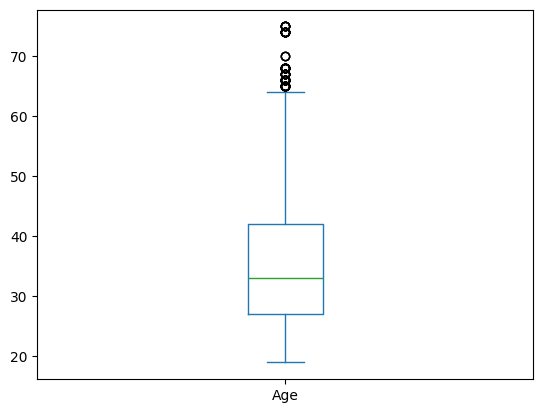

In [23]:
df["Age"].plot(kind="box")

Parce que la edad de 75 podria tratarse de un outlier grave, usemos el metodo de IQR para comprobar esta teoria.

In [36]:
def get_outliers_iqr(df: pd.DataFrame):
    """
    Identifica los valores atípicos (outliers) en un DataFrame numérico utilizando el método IQR.

    Args:
        df (pd.DataFrame): DataFrame que contiene los datos a analizar.

    Returns:
        dict[str, dict[str, list]]: Un diccionario donde las claves son los nombres de las columnas 
        numéricas y los valores son subdiccionarios con tres listas de outliers clasificados en:
        - "leves": valores fuera de [Q1 - 1.5*IQR, Q3 + 1.5*IQR]
        - "moderados": valores fuera de [Q1 - 3*IQR, Q3 + 3*IQR], excluyendo los leves
        - "graves": valores fuera de [Q1 - 4.5*IQR, Q3 + 4.5*IQR], excluyendo los moderados
    """
    outliers = {}

    for col in df.select_dtypes(include=["number"]).columns:  # Solo columnas numéricas
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound_1 = Q1 - 1.5 * IQR  # Límite para outliers leves
        upper_bound_1 = Q3 + 1.5 * IQR

        lower_bound_2 = Q1 - 3 * IQR  # Límite para outliers moderados
        upper_bound_2 = Q3 + 3 * IQR

        lower_bound_3 = Q1 - 4.5 * IQR  # Límite para outliers graves
        upper_bound_3 = Q3 + 4.5 * IQR

        leves = df[(df[col] < lower_bound_1) | (df[col] > upper_bound_1)][col]
        moderados = df[(df[col] < lower_bound_2) | (df[col] > upper_bound_2)][col]
        graves = df[(df[col] < lower_bound_3) | (df[col] > upper_bound_3)][col]

        outliers[col] = {
            "leves": sorted(leves.unique().tolist()),
            "moderados": sorted(moderados.unique().tolist()),
            "graves": sorted(graves.unique().tolist()),
        }

    return outliers

In [35]:
get_outliers_iqr(df)

{'Age': {'leves': [65, 66, 67, 68, 70, 74, 75], 'moderados': [], 'graves': []}}

No se trata de outliers graves, y ademas, tiene sentido que personas de edad avanzada pidan prestamos tambien, no eliminaremos estos "outliers".

# Verificando la precision
Finalmente, una de las mejoras formas de verficar la precision de los datos es al compararlos con reglas de negocio establecidas. El negocio tiene definidas reglas que sus datos deben de seguir, si estos no las cumplen en gran medida estariamos hablando de datos con una baja precision. 

Supongamos la siguiente regla de negocio. El banco decidio que no le prestaria dinero a aquellas personas menores de 22 años y mayores de 74 años. 

Verifiquemos cuantos registros incumplen dicha regla.

In [ ]:
df[(df["Age"] < 22) | (df["Age"] > 74)]  # 132 personas incumplen la regla de negocio

,Risk,Age
2,bad,21
5,good,20
39,bad,20
55,good,21
143,good,20
...,...,...
4736,good,20
4737,good,21
4748,good,20
4753,bad,20


In [38]:
(len(df[(df["Age"] < 22) | (df["Age"] > 74)]) / len(df["Age"])) * 100

2.8947368421052633

Solamente un 3% del total de registros incumplen la regla de negocio, no es para nada relevante.

# Conclusiones
Pudimos alcanzar cada uno de los objetivos propuestos al inicio de este notebook.

En la siguiente tabla se encuentran los indicadores obtenidos:

|Indicador |Descripcion |
|-|-|
|Validez |Se obtuvo una validez sub optima, los distribucion de los datos se encuentra altamente sesgada habiendo muchos mas datos de un grupo etario que de otro. |
|Veracidad |Se obtuvo una veracidad optima, habiendo muy poca presencia de valores nulos y ninguna presencia de outliers moderados o graves. |
|Precision |Se obtuvo una precision del 97%, con solo un 3% de datos que no cumplen con la regla de negocio supuesta. |
